In [1]:
# Load packages
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/sod'

# Set path to be the directory:
os.chdir(path)

In [3]:
# Load branch data:
sod = pd.read_csv('sod_data.csv', header=0, sep=',')
#inst = pd.read_csv('sod_data_ins.csv', header=0, sep=',')

C:\Users\angel\AppData\Local\Temp\ipykernel_22640\2809252724.py:2: DtypeWarning: Columns (13,28,50,59,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  sod = pd.read_csv('sod_data.csv', header=0, sep=',')


In [4]:
# show columns 13,28,50,59,60,62:
cols = [13,28,50,59,60,62]

# Specify dtypes for col 13, 28, 50, 59, 60, 62:
sod.iloc[:,cols].dtypes

DEPSUMBR    object
NECNAMB     object
ASSET       object
DEPDOM      object
DEPSUM      object
ESCROW      object
dtype: object

In [5]:
# Take commas away from columns 13, 28, 50, 59, 60, 62 so we can convert them to numeric:
sod.iloc[:,cols] = sod.iloc[:,cols].replace(',', '', regex=True)
#inst.iloc[:,cols] = inst.iloc[:,cols].replace(',', '', regex=True)

In [6]:
# Convert DEPSUMBR to numeric:
sod['DEPSUMBR'] = pd.to_numeric(sod['DEPSUMBR'], errors='coerce')

In [7]:
# Value in USD 
print('Deposits in 1996:', sod[sod['YEAR']==1996]['DEPSUMBR'].sum())

# Take the totals for every year and send to Jason. 

Deposits in 1996: 3328302607


In [8]:
# Create dataset excluding the HQ:
df = sod[sod['BKMO']==0]

In [9]:
# Aggregate deposits over MSA per year, it will be useful later...
df_grouped_msa = df.groupby(['MSANAMB', 'YEAR'])['DEPSUMBR'].sum().reset_index(name='total_msa')

# Aggregate all deposits over US per year:
df_grouped_msa['total_US'] = df_grouped_msa.groupby('YEAR')['total_msa'].transform('sum')

# Share of deposits in each MSA, per year:
df_grouped_msa['share_msa'] = df_grouped_msa['total_msa']/df_grouped_msa['total_US']

In [10]:
# Share of deposits in each MSA, per year:
df_grouped_msa['share_msa'] = df_grouped_msa['total_msa']/df_grouped_msa['total_US']

In [11]:
# Sanity check, sum of share_msa per year should be 1:
df_grouped_msa.groupby('YEAR')['share_msa'].sum()

YEAR
1994    1.0
1995    1.0
1996    1.0
1997    1.0
1998    1.0
1999    1.0
2000    1.0
2001    1.0
2002    1.0
2003    1.0
2004    1.0
2005    1.0
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
2023    1.0
Name: share_msa, dtype: float64

In [12]:
# This line is calculating the total deposits per MSANAMB and year (summing among all IDs). To see this run the following test:
print(df[(df['MSANAMB']=='Orlando-Kissimmee-Sanford, FL') & (df['YEAR']==2022)]['DEPSUMBR'].sum())
df_grouped_msa[(df_grouped_msa['MSANAMB']=='Orlando-Kissimmee-Sanford, FL') & (df_grouped_msa['YEAR']==2022)]
# Note that all rows have the same value for total.

73973332


,MSANAMB,YEAR,total_msa,total_US,share_msa
7926,"Orlando-Kissimmee-Sanford, FL",2022,73973332,11761891958,0.006289


In [13]:
# Compute the share of deposits per ID and year, note that the total deposits per MSANAMB is in the df_grouped dataset:
df = pd.merge(df, df_grouped_msa, on=['MSANAMB', 'YEAR'], how='left')

# Sort values by MSA and year:
df = df.sort_values(by=['MSANAMB', 'YEAR'])

In [14]:
# Create an ID variable that is equal to RSSDHCR, and if RSSDHCR==0 then ID=RSSDID:
df['ID'] = np.where(df['RSSDHCR']==0, df['RSSDID'], df['RSSDHCR']) 

In [15]:
df[df['ID']==0] # matches with jason until here

,YEAR,CERT,BRNUM,UNINUMBR,NAMEFULL,ADDRESBR,CITYBR,CNTYNAMB,STALPBR,ZIPBR,...,SPECDESC,STCNTY,STNAME,USA,Metrobr,Microbr,total_msa,total_US,share_msa,ID
499176,2000,35329,3,290911.0,Beacon Federal,7 Technology Park Drive,Westford,Middlesex,MA,1886.0,...,CONSUMER LENDING,36067,New York,1,NaN,NaN,74864134.0,2.532624e+09,0.029560,0
575378,2001,35329,3,290911.0,Beacon Federal,7 Technology Park Drive,Westford,Middlesex,MA,1886.0,...,CONSUMER LENDING,36067,New York,1,NaN,NaN,73718798.0,2.694996e+09,0.027354,0
499177,2000,35329,5,290913.0,Beacon Federal,765 West Poplar Avenue,Collierville,Shelby,TN,38017.0,...,CONSUMER LENDING,36067,New York,1,NaN,NaN,9874455.0,2.532624e+09,0.003899,0
575379,2001,35329,5,290913.0,Beacon Federal,765 West Poplar Avenue,Collierville,Shelby,TN,38017.0,...,CONSUMER LENDING,36067,New York,1,NaN,NaN,10484072.0,2.694996e+09,0.003890,0
499174,2000,35329,4,290912.0,Beacon Federal,"509 Enon Springs Road East, Suite 1",Smyrna,Rutherford,TN,37167.0,...,CONSUMER LENDING,36067,New York,1,NaN,NaN,15923725.0,2.532624e+09,0.006287,0
575375,2001,35329,4,290912.0,Beacon Federal,105 Threet Industrial Road,Smyrna,Rutherford,TN,37167.0,...,CONSUMER LENDING,36067,New York,1,NaN,NaN,15742913.0,2.694996e+09,0.005842,0
499173,2000,35329,2,290910.0,Beacon Federal,1330 Old Omen Road,Tyler,Smith,TX,75701.0,...,CONSUMER LENDING,36067,New York,1,NaN,NaN,1518869.0,2.532624e+09,0.000600,0
575376,2001,35329,2,290910.0,Beacon Federal,1330 Old Omen Road,Tyler,Smith,TX,75701.0,...,CONSUMER LENDING,36067,New York,1,NaN,NaN,1626577.0,2.694996e+09,0.000604,0
499175,2000,35329,1,290909.0,Beacon Federal,5248 Manchester Highway,Morrison,Warren,TN,37357.0,...,CONSUMER LENDING,36067,New York,1,NaN,NaN,NaN,NaN,NaN,0
574933,2001,34966,1,359307.0,First Capital Bank,1503 Atkinson St,Laurinburg,Scotland,NC,28352.0,...,COMMERCIAL LENDING,45069,South Carolina,1,NaN,NaN,NaN,NaN,NaN,0


In [16]:
# Compute the total amount of deposits per NAMEHCR, in each MSA and year:
df_grouped_id = df.groupby(['ID', 'MSANAMB', 'YEAR'])['DEPSUMBR'].sum().reset_index(name='total_id')

df = pd.merge(df, df_grouped_id, on=['ID', 'MSANAMB', 'YEAR'], how='left')

In [17]:
# Compute share of deposits per NAMEHCR, in each MSA and year:
df['share_id'] = 100*(df['total_id']/df['total_msa'])
df['share_id_sq'] = df['share_id']**2


In [18]:
df[(df['ID']==61832) & (df['YEAR']==1994) & (df['MSANAMB']=='Orlando-Kissimmee-Sanford, FL')] # checks with Jason until here

,YEAR,CERT,BRNUM,UNINUMBR,NAMEFULL,ADDRESBR,CITYBR,CNTYNAMB,STALPBR,ZIPBR,...,USA,Metrobr,Microbr,total_msa,total_US,share_msa,ID,total_id,share_id,share_id_sq
1323325,1994,3579,2,201312.0,The First National Bank of Mount Dora,2500 Eudora Road,Mount Dora,Lake,FL,32757.0,...,1,NaN,NaN,9373560.0,1.905197e+09,0.00492,61832,15645.0,0.166906,0.027857
1323326,1994,3579,1,201311.0,The First National Bank of Mount Dora,8570 Highway 46,Sorrento,Lake,FL,32776.0,...,1,NaN,NaN,9373560.0,1.905197e+09,0.00492,61832,15645.0,0.166906,0.027857


In [19]:
# Take the columns ID, YEAR, MSANAMB, and share_id_sq and take uniques on IDs, keep only those columns:
df_grouped_id_sq = df[['ID', 'YEAR', 'MSANAMB', 'share_id_sq']].drop_duplicates()
 

In [20]:
# Sum all the share_id_sq per MSANAMB and year:
df_grouped_id_sq = df_grouped_id_sq.groupby(['MSANAMB', 'YEAR'])['share_id_sq'].sum().reset_index(name='HHI')

In [21]:
df_grouped_id_sq

,MSANAMB,YEAR,HHI
0,"Abilene, TX",1994,1486.737264
1,"Abilene, TX",1995,1375.208961
2,"Abilene, TX",1996,1339.587939
3,"Abilene, TX",1997,1680.888096
4,"Abilene, TX",1998,1606.102438
...,...,...,...
11658,"Yuma, AZ",2019,2201.800786
11659,"Yuma, AZ",2020,2221.139816
11660,"Yuma, AZ",2021,2217.620552
11661,"Yuma, AZ",2022,2159.199829


In [22]:
# sum the squared shares of deposits per MSA, per year:
df_HHI = df_grouped_id_sq[['YEAR', 'MSANAMB', 'HHI']].drop_duplicates()

In [23]:
df_HHI = pd.merge(df_HHI, df_grouped_msa, on=['MSANAMB', 'YEAR'], how='left')

In [24]:
df_HHI['log_deposits'] = np.log(df_HHI['total_msa'])

In [25]:
df_HHI[(df_HHI['YEAR']==1994) & (df_HHI['MSANAMB']=='Orlando-Kissimmee-Sanford, FL')]

,YEAR,MSANAMB,HHI,total_msa,total_US,share_msa,log_deposits
7898,1994,"Orlando-Kissimmee-Sanford, FL",1461.089695,9373560,1905196736,0.00492,16.053404


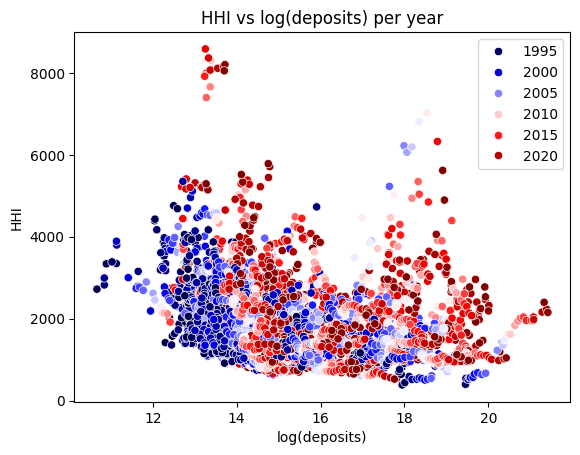

In [26]:
# plot a scatter plot of the HHI per log('DEPSUMBR') per year, I want the dots for each year to have different collors:
sns.scatterplot(data=df_HHI, x='log_deposits', y='HHI', hue='YEAR', palette='seismic')
plt.legend()
plt.title('HHI vs log(deposits) per year')
plt.xlabel('log(deposits)')
plt.ylabel('HHI')
plt.savefig('HHI_vs_log_deposits.png')
plt.show()


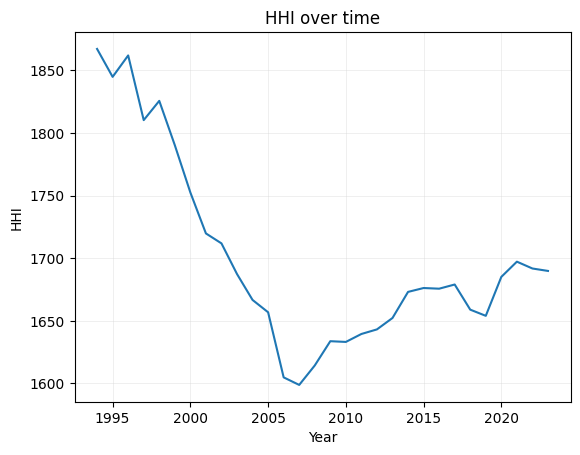

In [27]:
# Aggregate to get one HHI per year, averaging over MSAs:
df_HHI = df_HHI.groupby('YEAR')['HHI'].mean().reset_index(name='HHI')

# Plot HHI over time:
plt.plot(df_HHI['YEAR'], df_HHI['HHI'])
plt.xlabel('Year')
plt.ylabel('HHI')
plt.title('HHI over time')
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.savefig('HHI_over_time.png')
plt.show()

In [28]:
# temporary dataset
temp = df[['ID', 'YEAR', 'MSANAMB', 'share_id_sq', 'share_msa']].drop_duplicates()

# compute HHI per MSA and year
wHHI = temp.groupby(['MSANAMB', 'YEAR'])['share_id_sq'].sum().reset_index(name='HHI')

df_wHHI = pd.merge(df[['MSANAMB', 'YEAR', 'share_msa']], wHHI, on=['MSANAMB', 'YEAR'], how='left').drop_duplicates()


In [29]:
# Average HHI over MSAs, weighting by 'share_msa' to get one value per year:
df_wHHI['wHHI'] = df_wHHI['HHI']*df_wHHI['share_msa']

# sum wHHI variable per year:
df_wHHI = df_wHHI.groupby('YEAR')['wHHI'].sum().reset_index(name='wHHI')


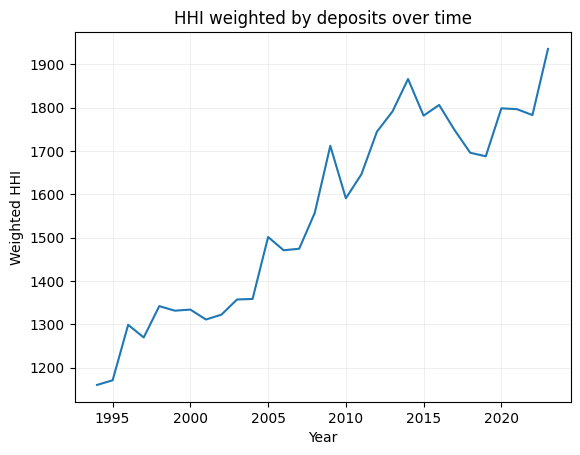

In [30]:
# plot wHHI over time:
plt.plot(df_wHHI['YEAR'], df_wHHI['wHHI'])
plt.xlabel('Year')
plt.ylabel('Weighted HHI')
plt.title('HHI weighted by deposits over time')
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.savefig('wHHI_over_time.png')
plt.show()